In [19]:
import os
import sys
import copy
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.12.1
Torchvision Version:  0.13.1


In [22]:
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from model.models import Conv4

In [13]:
MODEL_DIR = "../model/weight/"
LOG_DIR = "../results/log/"

In [31]:
conf = dict(
    epoch=50,
    lr=0.01,
    stepsize=50,
    gamma=0.1,
    model="Conv4",
    mode="pretrain",
    dataset="cifar10",
    finetune="custom"
)

setting = "epoch"+str(conf['epoch'])+"_lr"+str(conf['lr'])+"_stepsize"+str(conf['stepsize']) + "_gamma"+str(conf['gamma'])
if str(conf["mode"]) == "pretrain":
    name = str(conf['model'])+"/"+str(conf['dataset'])+"_"+setting
else :
    name = str(conf['finetune'])+"/"+str(conf['model'])+"/"+str(conf['dataset'])+"_"+setting
model_path = MODEL_DIR + str(conf['mode']) + "/" + name + ".pt"
log_path = LOG_DIR + str(conf['mode']) + "/" + name

print(model_path)
print(log_path)

../model/weight/pretrain/Conv4/cifar10_epoch50_lr0.01_stepsize50_gamma0.1.pt
../results/log/pretrain/Conv4/cifar10_epoch50_lr0.01_stepsize50_gamma0.1


### Architecture

In [32]:
def select_model(model_name):
    if model_name == 'Conv4':
        model = Conv4()
    # elif model_name == 'Conv8':
    #     model = Conv8()
    # elif model_name == 'Conv12':
    #     model = Conv12()
    else:
        raise ValueError(f'Undefined Model.')
    
    return model

In [33]:
model = select_model(conf['model'])
model_state = torch.load(model_path)
model.load_state_dict(model_state)

<All keys matched successfully>

In [34]:
summary(model, (3, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             448
            Conv2d-2           [-1, 32, 14, 14]           4,640
         MaxPool2d-3             [-1, 32, 7, 7]               0
            Conv2d-4             [-1, 64, 4, 4]          18,496
            Conv2d-5            [-1, 128, 4, 4]          73,856
         MaxPool2d-6            [-1, 128, 2, 2]               0
            Linear-7                   [-1, 10]           5,130
Total params: 102,570
Trainable params: 102,570
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.39
Estimated Total Size (MB): 0.51
----------------------------------------------------------------


### Log Print

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Loss/train', 'Acc/train', 'Loss/val', 'Acc/val'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


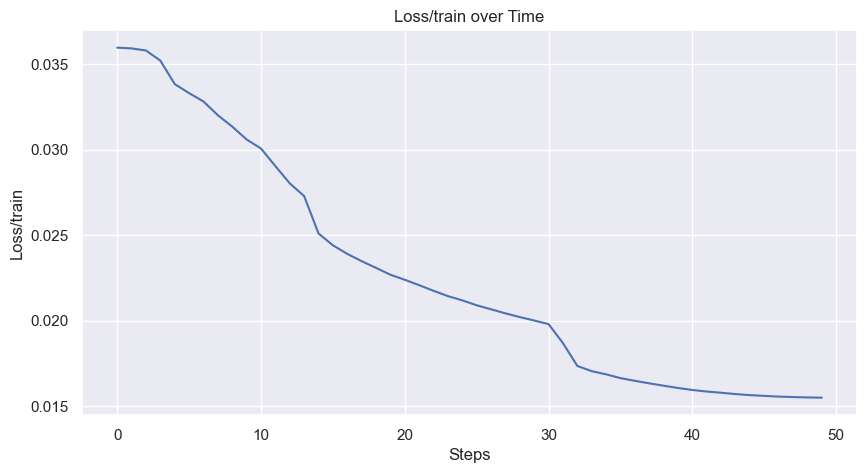

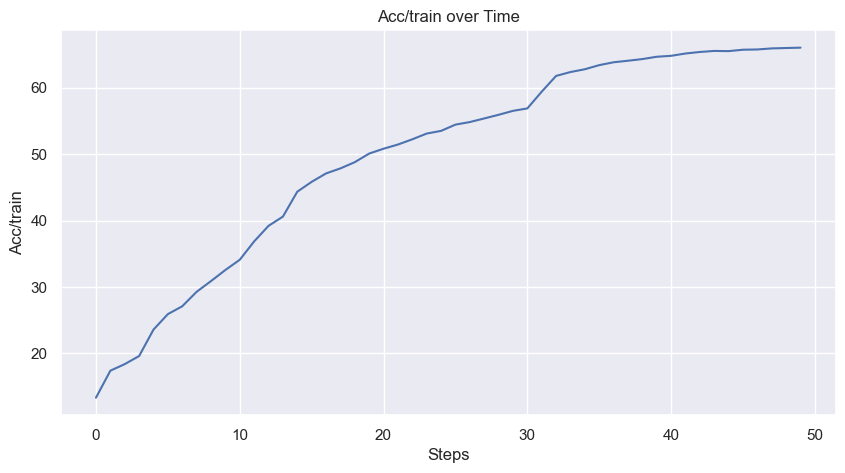

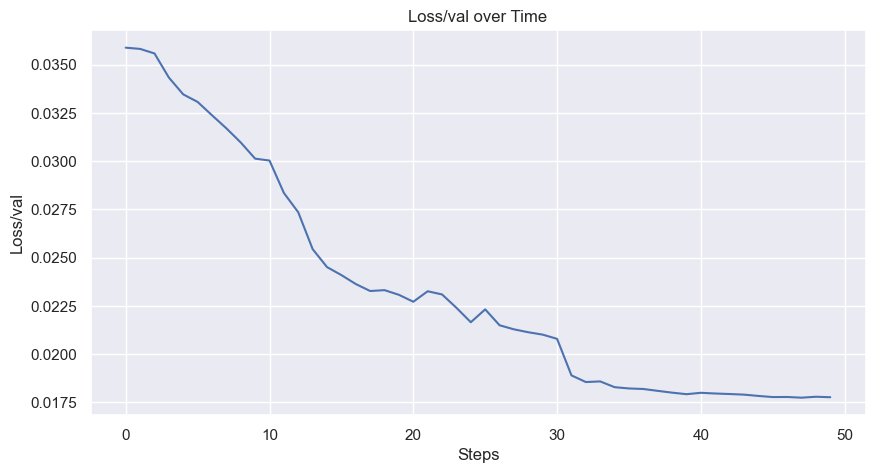

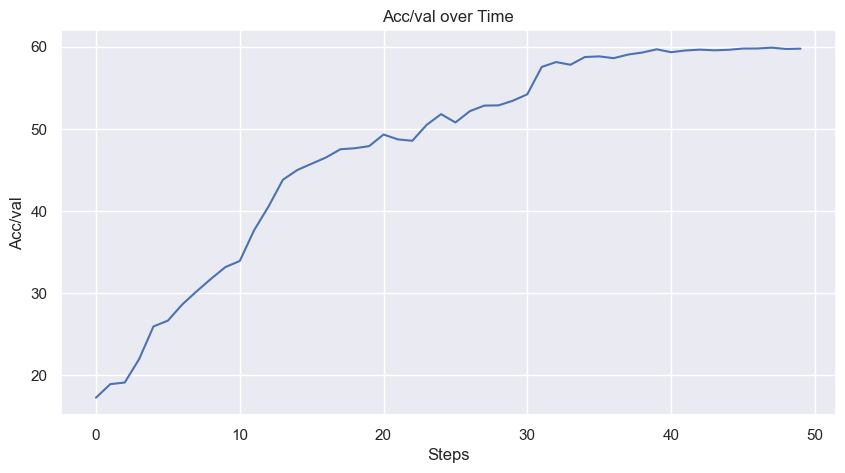

In [36]:
event_acc = EventAccumulator(log_path)
event_acc.Reload()

print(event_acc.Tags())

if 'scalars' in event_acc.Tags():
    scalar_tags = event_acc.Tags()['scalars']

    plt.figure(figsize=(15, 10))
    sns.set()

    for i, tag in enumerate(scalar_tags):
        values = event_acc.Scalars(tag)
        steps = [v.step for v in values]
        data = [v.value for v in values]
        
        df = pd.DataFrame({'Step': steps, tag: data})

        plt.subplot(2, 2, i + 1)
        sns.lineplot(x='Step', y=tag, data=df)
        plt.xlabel('Steps')
        plt.ylabel(tag)
        plt.title(f'{tag} over Time')

    plt.tight_layout()
    plt.show()

### Visualization